# Intro to Autoencoders

In this project we will look at autoencoders with three examples. We will begin with the basics to see if we can duplicate an image. We will then move on to denoising or cleaning up an image, and finish with anomaly detection.

An autoencoder is a type of nueral network that is trained to copy its input to its output. An autoencoder essentially takes an image, encodes it into a lower dimension (compressess it) and then is able to decode the lower dimension data to reproduce the original image. Why would we want to do this? We can apply different functions to the data when we encode the compressed version of the image.

<br>

---

<br>

We will begin by importing our dependencies:

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset

We will now load our data. We will be using the Fashion MNIST dataset, which we further explored in my [Image Recognition Project](https://www.bradconlin.net/projects/basic-image-recognition).

<br>

We will train our autoencoder on these simple images (28x28 pixels), and the modify from there.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder

Our first autoencoder will just complete the basic function of an autoencoder sos we can better see the results.

<br>

![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

We will define an autoencoder with two Dense layersss:

- Encoder: compresses the image(s) into a 64 dimensional latent vector
- Decoder: reconstructs the original image from the latent space


<br>


In [3]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

We will use `x_train` for both the input and the target, since we want to recreate the original image.

- The `encoder` layer will learn to compress the dataset from the 784 (28x28)
- The `decoder` will learn how to reconstruct the original images.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 4ms/step - loss: 0.0237 - val_loss: 0.0135
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.00

Now that we have the model trained, we can test it on ssome images.

The following code will segment out for us and then display the `original` image and then the `reconstructed` image.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

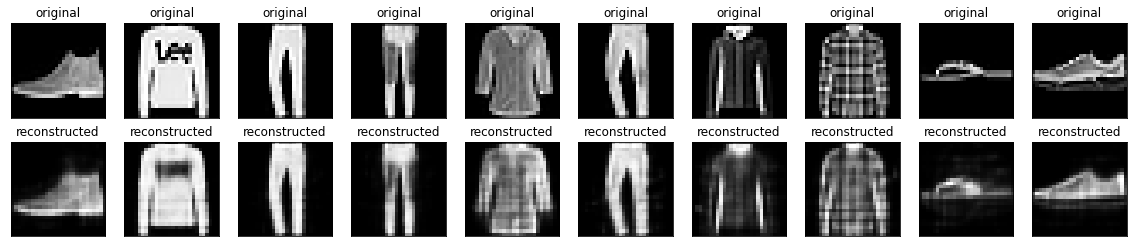

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

We can see from the image above that our model did a decent job at reconstructing the imagess. Personally, the sandals are the only class that I would say is less than ideal.

<br>

---

## Second example: Image denoising


We can use autoencoders to remove noise or unwanted characteristics of an image. 

In this example we will add noise to the images from the Fashion MNIST dataset, and then use the original as our target. This will help train the model how to remove noise from an image. 

*Note: This is a little different because we use the image twice, as the test and label, but given we are using images, we cannot use a simple label like in other applicationss.* 

![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)


<br>

---

<br>

We will reimport the dataset to remove any modification we made previously.

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


We will add the noise to the images with a float, and in this case, we will use a factor of `0.2`

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

We can now plot the noisy images for better understanding.


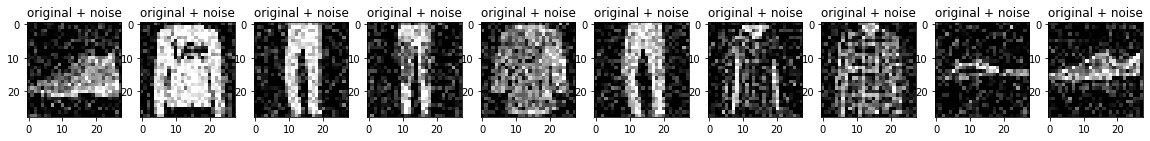

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

We will train a convolutional autoencoder using  `Conv2D` layers in the `encoder`, and `Conv2DTranspose` layers in the `decoder`.

In [12]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 16s 4ms/step - loss: 0.0165 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.00

We can now look at the summary of what we just did with the `encoder`.

Note: Notice how the original 28x28 imagess are downsampled to 14x14 and then finally 7x7.

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder then upsamples the images back up to 28x28.

In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


We can now plot the original "noisy" images, and the reconstructed images.

In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

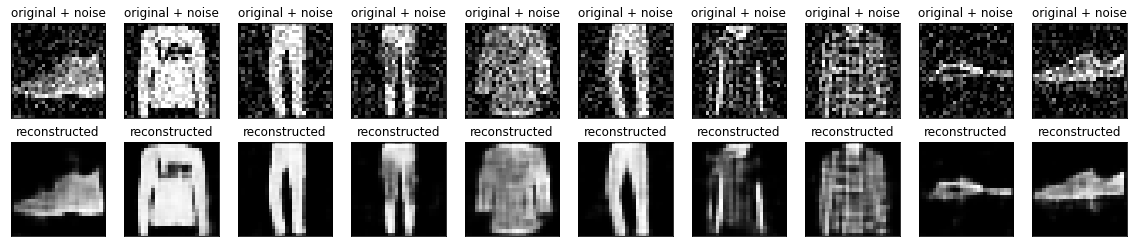

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

In this example we will train an autoencoder to detect anomaliess on the `ECG5000` dataset. This dataset comntains 5,000 electrocardiograms, each with 140 dimensions. 

This is a more simplified dataset, containing the labels we need; `0` for abnormal rhythm, or `1` for a normal rhythm. We are interested in the abnormal rhythms, hence the anomaly detection aspect.

---

<br>

How will we use an autoencoder to detect anomalies? Autoencoders are trained to minimize the reconstruction error, more simply put, they are trained to be as accurate as possible at recreating an image.

We will train an autoencoder on the normal rythms (`1`) only, then we can use this model to reconstruct all the data. We can then create a cut-off for the reconsstruction error to help us identify normal and abnormal rythms.

### Load ECG data

In [19]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


We will now create our training data and split out the labels, and then normalize our data with the following codeblocks:

In [20]:
labels = raw_data[:, -1]

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [21]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

We will now separate out the normal and abnormal rythms so we can train our autoencoder on the normal rythms only.

*Nore: Normal Rythms =* `1`

In [22]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

We will now plot a normal ECG rythm, followed by an abnormal rythm.

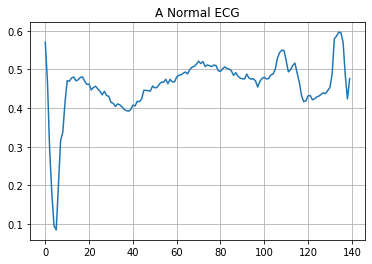

In [23]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

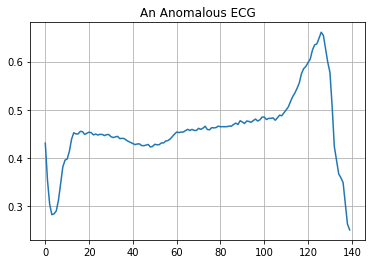

In [24]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

We are now ready to build our model. *Please remember that our model contains both an encoder, followed by a decoder*

<br>

We will use the following codeblock to build our model, followed by compiling the model for use on the complete dataset (now including abnormal rythms).

In [25]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [26]:
autoencoder.compile(optimizer='adam', loss='mae')

You will notice that we have trained the encoder on the normal rythms, but we are evaluating on the complete (contains: normal and abnormal rythms) test dataset. This is on purpose and will be clear soon as to why.

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0574 - val_loss: 0.0527
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0552 - val_loss: 0.0509
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0523 - val_loss: 0.0491
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0488 - val_loss: 0.0474
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0449 - val_loss: 0.0459
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0412 - val_loss: 0.0436
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0373 - val_loss: 0.0417
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0338 - val_loss: 0.0402
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0309 - val_loss: 0.0390
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0287 - val_loss: 0.0382
Epoch 11/20
5/5 [==================

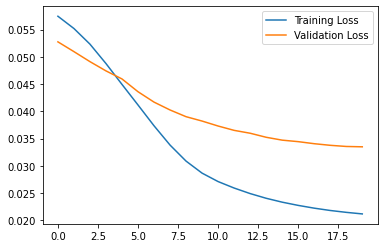

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

We will now classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training data.

However, let us first plot:

1. a normal ECG, the ECG after reconstruction, and then the reconstruction error.
2. The same as above, but with an anomalous ECG

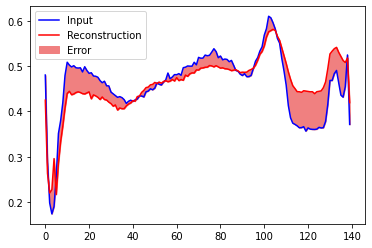

In [29]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

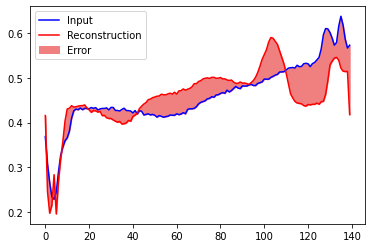

In [30]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

We can now detect anomalies by calculating whether the reconstruction loss is greater than our fixed threshhold of one standard deviation. We will do this by calculating the mean average error for our normal ECG examples from the training set. Then we will classsify future ECG examples as anomalous if the reconstruction error is higher than our threshold.

<br>

Let us plot the reconstruction error of a normal ECG from our training set.


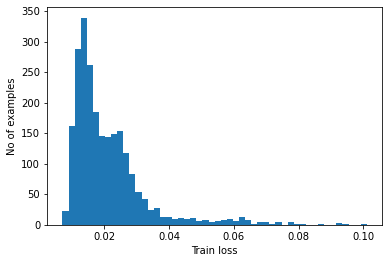

In [31]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

We will now create our threshold and then display it:

In [32]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03288473


We can now examine the reconstruction error of the anomalous records, and we will see that the average reconstruction error is significantly higher than that of the normal train data seen previous.

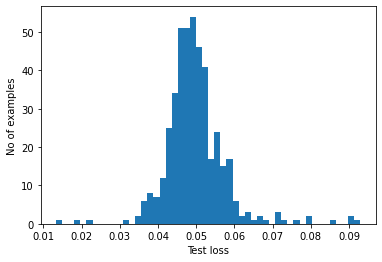

In [33]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

We can now classify an ECG as an anomalous if the reconstruction error is greater than our threshold. 

In [34]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [35]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714


That is pretty awesome! We were able to take a relatively small dataset and train an autoencoder to find health related problems with patients. 

# Conclusion

I would like to recommend you try these techniques out on your own datasets or maybe try one from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)!